In [1]:
# Python packages
import matplotlib.pyplot as plt
import pickle
import numpy as np
import sys
import os
import pickle
import signal
import argparse
import traceback
import json
import torch
from sklearn.decomposition import PCA
import pandas as pd

ImportError: Gtk3 backend requires pygobject to be installed.

In [2]:
# Project libraries
sys.path.insert(1, '../src/')

import embedding.factory as ebd
import dataset.loader as loader
import train.factory as train_utils

NameError: name 'sys' is not defined

In [3]:
cuda0 = torch.device('cuda:0')

## Arguments

In [6]:
# Build args
parser = argparse.ArgumentParser()
parser.add_argument("--data_path", type=str,
                        default="data/20news.json", # og: reuters
                        help="path to dataset")
parser.add_argument("--dataset", type=str, default="20newsgroup", # og: reuters
                    help="name of the dataset. "
                    "Options: [20newsgroup, amazon, huffpost, "
                    "reuters, rcv1, fewrel]")
parser.add_argument("--n_train_class", type=int, default=15,
                    help="number of meta-train classes")
parser.add_argument("--n_val_class", type=int, default=5,
                    help="number of meta-val classes")
parser.add_argument("--n_test_class", type=int, default=11,
                    help="number of meta-test classes")
parser.add_argument("--mode", type=str, default="test",
                    help=("Running mode."
                          "Options: [train, test, finetune]"
                          "[Default: test]"))
parser.add_argument("--wv_path", type=str,
                    default="./",
                    help="path to word vector cache")
parser.add_argument("--word_vector", type=str, default="wiki.en.vec",
                    help=("Name of pretrained word embeddings."))
parser.add_argument("--finetune_ebd", action="store_true", default=False,
                    help=("Finetune embedding during meta-training"))
parser.add_argument("--bert", default=False, action="store_true",
                    help=("set true if use bert embeddings "
                          "(only available for sent-level datasets: "
                          "huffpost, fewrel"))
parser.add_argument("--auxiliary", type=str, nargs="*", default=[],
                    help=("auxiliary embeddings (used for fewrel). "
                          "Options: [pos, ent]"))
parser.add_argument("--embedding", type=str, default="avg",
                    help=("document embedding method. Options: "
                          "[avg, tfidf, meta, oracle, cnn]"))
parser.add_argument("--meta_w_target", action="store_true", default=False,
                    help="use target importance score")
parser.add_argument("--cuda", type=int, default=-1,
                    help="cuda device, -1 for cpu")
parser.add_argument("--snapshot", type=str, default="",
                    help="path to the pretraiend weights")


# Populate parameters
args = parser.parse_args(["--data_path", "../data/20news.json",
                            "--dataset", "20newsgroup",
                            "--n_train_class", "8",
                            "--n_val_class", "5",
                            "--n_test_class", "7",
                            "--wv_path", "../",
                            "--cuda", "0",
                            "--finetune"
                            ])

print(vars(args))

{'data_path': '../data/20news.json', 'dataset': '20newsgroup', 'n_train_class': 8, 'n_val_class': 5, 'n_test_class': 7, 'mode': 'test', 'wv_path': '../', 'word_vector': 'wiki.en.vec', 'finetune_ebd': True, 'bert': False, 'auxiliary': [], 'embedding': 'avg', 'meta_w_target': False, 'cuda': 0, 'snapshot': ''}


## Load, Preprocess Data

In [160]:
train_data, val_data, test_data, vocab = loader.load_dataset(args)

20/03/30 13:50:24: Loading data from ../data/20news.json
20/03/30 13:50:25: Class balance:
{0: 940, 1: 987, 2: 972, 3: 775, 4: 973, 5: 991, 6: 980, 7: 985, 8: 910, 9: 628, 10: 990, 11: 990, 12: 961, 13: 981, 14: 999, 15: 799, 16: 994, 17: 982, 18: 994, 19: 997}
20/03/30 13:50:25: Avg len: 340.86015508816655
20/03/30 13:50:25: Loading word vectors


I0330 13:50:25.084720 140443841652544 vocab.py:431] Loading vectors from ../wiki.en.vec.pt


20/03/30 13:50:29: Total num. of words: 32137, word vector dimension: 300
20/03/30 13:50:29: Num. of out-of-vocabulary words(they are initialized to zeros): 9095
20/03/30 13:50:29: #train 7926, #val 4881, #test 6021


In [161]:
print(set(train_data['label']))

{1, 5, 10, 11, 13, 14, 16, 18}


In [162]:
print(set(test_data['label']))

{0, 2, 3, 8, 9, 15, 19}


In [163]:
# Aggregate all training, val, test data
data = {}

for key in test_data:
    if key == 'vocab_size':
        data['vocab_size'] = test_data[key]
        continue
        
    ax = 0 if key == 'text' else None
    concat = np.concatenate(
            (test_data[key], val_data[key], train_data[key]), axis=ax
        )
    
    if key == 'text':
        data[key] = torch.tensor(concat, device=cuda0)
    else:
        data[key] = concat

assert len(data['text']) == len(test_data['text']) + len(train_data['text']) + len(val_data['text'])

print('Dataset has {} documents, {} different labels and {} size vocabulary.'.format(
    len(data['text']), max(data['label']+1), data['vocab_size'])
)

Dataset has 18828 documents, 20 different labels and 32137 size vocabulary.


In [164]:
data.keys()

dict_keys(['text', 'text_len', 'label', 'raw', 'vocab_size'])

In [165]:
print(set(data['label']))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}


Due to memory constraints on the GPU, create a data "queue" of chunks of user-specified size, and embed the data one chunk (several documents) at a time. Each row in each resulting tensor corresponds to the document embedding (AVG, WORDEBD) of a document. We can access the original labels in __data__ and the tensors in __embed_queue__.

In [166]:
def chunk_data(chunk_size, data):
    """
    Chunks data into manageable sizes for processing
    
    Args:
        chunk_size (int): number of words for each chunk
        data (dict): data dictionary w keys 'text', 'vocab_size', etc
    
    Returns:
        list of dictionaries in order
    """
    chunk_list = []
    total_size = len(data['text'])
    cumu_size = 0
    
    while cumu_size < total_size:
        next_size = min(cumu_size + chunk_size, total_size)
        
        # Create chunk
        chunk = {
            'text' : torch.tensor(data['text'][cumu_size:next_size], device=cuda0),
            'text_len' : torch.tensor(data['text_len'][cumu_size:next_size], device=cuda0),
            'label' : torch.tensor(data['label'][cumu_size:next_size], device=cuda0),
            'raw' : data['raw'][cumu_size:next_size],
            'vocab_size' : data['vocab_size']
        }

        chunk_list.append(chunk)
        
        # Update cumulative size
        cumu_size = next_size
        
    return chunk_list

In [167]:
data_queue = chunk_data(50, data)
tr_data_queue = chunk_data(50, train_data)
te_data_queue = chunk_data(50, test_data)

model = {}
model["ebd"] = ebd.get_embedding(vocab, args)
embed = model['ebd']

/data/rsg/nlp/rmwu/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


20/03/30 13:50:48, Building embedding
Embedding type: WORDEBD
Using:  avg
20/03/30 13:50:48, Building embedding


In [168]:
# Embedded documents queue
tr_embed_queue = [embed(chunk) for chunk in tr_data_queue]
te_embed_queue = [embed(chunk) for chunk in te_data_queue]
embed_queue = [embed(chunk) for chunk in data_queue]


# Combine the embeddings together and create field in data dict
train_data['ebd'] = torch.cat(tr_embed_queue).cpu().detach().numpy()
test_data['ebd'] = torch.cat(te_embed_queue).cpu().detach().numpy()
data['ebd'] = torch.cat(embed_queue).cpu().detach().numpy()

In [16]:
all_df = pd.DataFrame(data['ebd'])
all_df.head(100)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.124415,-0.020417,-0.069346,0.091377,-0.079796,0.070282,0.075804,-0.216919,-0.046902,0.129846,...,0.010435,0.052237,0.007903,-0.090170,0.152281,-0.074729,-0.144545,0.105670,0.115511,0.104688
1,-0.075159,-0.003043,-0.099258,0.112942,-0.101508,0.008385,0.022061,-0.135841,0.004797,0.187534,...,0.043346,-0.013045,0.003885,-0.000979,0.027354,-0.040816,-0.111924,0.128747,0.056314,0.046071
2,-0.080389,-0.041529,-0.061312,0.103755,-0.086603,0.010311,0.038585,-0.187294,-0.017839,0.148724,...,0.020543,-0.000655,0.007602,-0.025330,0.072066,-0.079325,-0.086958,0.107416,0.077540,0.039650
3,-0.022361,-0.077752,-0.039378,0.090882,-0.096249,0.005133,0.028690,-0.152463,0.054856,0.201151,...,0.024943,-0.064121,0.042752,0.011391,0.035032,-0.111200,-0.067736,0.138786,0.059619,0.019695
4,-0.081447,-0.007211,-0.073106,0.097729,-0.103240,0.016781,-0.019609,-0.190727,0.014717,0.153712,...,0.015522,0.041751,0.010705,-0.079508,0.083521,-0.123763,-0.114408,0.143006,0.100094,-0.018870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-0.095174,-0.013247,-0.077830,0.119162,-0.073894,0.010618,0.018167,-0.195425,-0.012059,0.182049,...,0.024403,0.023333,-0.010742,-0.043991,0.058883,-0.080037,-0.106839,0.123544,0.080793,0.036533
96,-0.069868,-0.047623,-0.095615,0.153674,-0.068575,0.034050,0.026899,-0.179638,0.004796,0.188709,...,0.041883,-0.013060,0.021143,0.010844,0.025940,-0.066462,-0.110029,0.121081,0.030960,0.036877
97,-0.077197,-0.099006,-0.067128,0.148165,-0.098624,0.018120,0.008062,-0.162496,-0.013794,0.157968,...,0.031426,-0.050556,0.042869,0.029839,0.036257,-0.068043,-0.103222,0.081063,0.069935,0.033167
98,-0.082979,-0.050510,-0.045994,0.121490,-0.070642,0.000380,0.008936,-0.173120,0.015073,0.140621,...,0.067901,-0.045484,0.006674,0.032102,0.044224,-0.060718,-0.081409,0.107732,0.050481,0.065085


In [17]:
# Show embedding df
tr_df = pd.DataFrame(train_data['ebd'])

tr_df.head(100)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.071192,-0.012361,-0.085839,0.136673,-0.088308,0.000446,0.011034,-0.143944,-0.026524,0.135350,...,0.062775,-0.018588,0.000405,-0.019892,0.041033,-0.107942,-0.057266,0.129144,0.099781,0.061606
1,-0.041846,-0.024256,-0.079570,0.159294,-0.090971,0.018244,-0.033902,-0.139918,0.029066,0.116877,...,0.079000,-0.111922,0.022248,0.036722,0.001079,-0.125525,-0.087844,0.148737,0.047283,0.021140
2,-0.070470,0.009819,-0.071082,0.150578,-0.086470,0.033564,0.001022,-0.165744,-0.010373,0.129809,...,0.057856,-0.029996,0.034615,0.004137,0.032689,-0.107052,-0.077811,0.157702,0.092626,0.052546
3,-0.071521,-0.008882,-0.042624,0.132055,-0.091530,0.002158,0.027034,-0.151465,-0.012600,0.132218,...,0.058395,-0.001610,0.017042,0.058495,0.050868,-0.132523,-0.080150,0.126434,0.072268,0.015644
4,-0.085329,-0.015131,-0.050789,0.117801,-0.070769,0.011131,0.022904,-0.120538,0.052579,0.066595,...,0.055565,-0.101711,0.013240,0.004888,0.039110,-0.077845,-0.125016,0.133442,0.115185,0.027180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-0.083635,-0.028580,-0.080969,0.130626,-0.105474,0.020523,-0.004547,-0.154977,-0.008059,0.141302,...,0.044397,-0.013539,0.010918,-0.005697,0.057695,-0.074778,-0.058086,0.143707,0.097171,0.047469
96,-0.078949,-0.003455,-0.064119,0.105644,-0.087107,0.010494,0.000608,-0.153609,-0.013248,0.165260,...,0.059539,-0.012643,0.016921,0.007850,0.045486,-0.096417,-0.088853,0.137824,0.068355,0.061161
97,-0.066152,-0.014906,-0.034030,0.082242,-0.089661,0.009507,0.031910,-0.156900,0.010539,0.107461,...,0.066905,-0.046841,0.022918,0.019186,0.063436,-0.086365,-0.104695,0.121863,0.113497,0.045664
98,-0.130918,-0.148796,0.120990,0.047321,-0.138596,-0.084153,0.004985,-0.043948,-0.000484,0.087553,...,0.090146,-0.083179,0.058428,0.044482,0.086092,-0.151272,0.025468,0.029642,0.067901,0.099497


In [169]:
te_df = pd.DataFrame(test_data['ebd'])

### Get Topic Embed Vectors

In [170]:
with open('../20news_reps_cache_.json') as json_file:
                topics = json.load(json_file) 
topics = pd.DataFrame.from_dict(topics, orient='index')

In [171]:
topics

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.152460,-0.590110,0.079915,0.333420,-0.088485,0.112700,-0.114920,-0.579780,-0.036263,0.006680,...,-0.013480,-0.017638,0.620890,-0.043418,0.052670,0.565990,-0.065357,-0.507710,0.120370,0.155420
1,0.152330,0.018883,0.248440,0.308760,0.321930,0.103750,-0.057328,-0.046788,-0.040007,-0.103820,...,0.013078,-0.107090,-0.440320,-0.039817,0.092986,0.119560,0.216730,0.292790,0.199520,0.371760
2,-0.268800,-0.027697,-0.176130,0.006205,0.273210,0.251530,-0.038377,-0.224650,-0.079456,-0.063992,...,0.107190,0.075985,-0.008486,0.081589,0.020419,-0.295520,-0.237230,0.270260,0.266110,-0.309050
3,-0.118620,-0.427520,0.046964,0.087433,0.079440,0.081076,0.119380,-0.400020,0.162500,0.269940,...,0.005722,-0.055203,0.026619,-0.240140,0.164890,0.130810,-0.019985,-0.330250,0.159130,-0.100920
4,-0.176940,0.161100,0.105950,-0.067230,-0.229590,0.411750,-0.078765,-0.151860,-0.090426,0.410520,...,0.245870,-0.182870,-0.230340,0.230250,0.619600,0.082631,-0.155040,0.051455,0.261910,-0.157840
5,-0.021599,-0.014969,0.232980,0.506390,0.120210,0.154890,0.336940,-0.048732,-0.188950,-0.092081,...,-0.083593,-0.241590,0.198530,-0.017753,0.597070,0.093406,-0.303690,0.127090,0.454480,0.297170
6,0.090756,0.057117,0.175240,0.251990,0.219760,-0.042760,-0.394500,-0.152950,-0.091411,0.223100,...,0.238290,-0.275390,-0.081909,0.113340,0.345570,-0.045735,-0.270670,0.018656,-0.162090,0.046151
7,0.092204,-0.090641,0.091374,-0.073267,-0.081702,-0.139190,-0.348250,-0.232600,-0.514780,0.006573,...,0.250680,-0.361000,-0.021109,-0.120420,0.656580,-0.057016,-0.161310,0.196450,-0.184110,-0.159880
8,0.090107,-0.112140,-0.186160,0.355300,0.044789,0.493980,-0.371220,-0.091334,0.031132,-0.034730,...,0.618040,-0.155920,0.190280,-0.006354,0.017190,-0.117730,-0.261050,0.137060,0.248140,-0.057017
9,-0.283170,-0.112300,0.039923,0.457030,-0.330840,0.445530,0.126350,-0.215070,-0.041685,0.374010,...,0.069616,-0.077255,-0.029674,-0.396780,-0.079598,0.130320,-0.221790,0.129340,-0.232840,-0.052929


In [28]:
# Add embeddings
all_df = pd.concat([all_df, topics])

# Add topic labels to overall label list
labels = np.concatenate((data['label'], range(20)), axis=None) 

# Create indicators whether a row is a topic or a document
is_topic = [0 if i<len(data['text']) else 1 for i in range(len(all_df))]

In [29]:
assert len(all_df) == len(labels) == len(is_topic)

In [27]:
classes = [
        'mideast', 'space', 'sale', 'politics', 'graphics',
        'cryptography', 'windows', 'microsoft', 'guns',
        'religion', 'autos', 'medicine', 'mac', 'electronics',
        'hockey', 'atheism', 'motorcycles', 'pc', 'baseball', 'christian'
]

# KNN?

In [53]:
from sklearn.model_selection import train_test_split 

In [55]:
X = all_df
y = data['label']

In [56]:
X_train, X_test, y_train, y_test = train_test_split( 
             X, y, test_size = 0.2, random_state=42) 

In [57]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

/data/rsg/nlp/rmwu/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/data/rsg/nlp/rmwu/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  """
/data/rsg/nlp/rmwu/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  


In [58]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [59]:
y_pred = classifier.predict(X_test)

In [63]:
classes = [
        'mideast', 'space', 'sale', 'politics', 'graphics',
        'cryptography', 'windows', 'microsoft', 'guns',
        'religion', 'autos', 'medicine', 'mac', 'electronics',
        'hockey', 'atheism', 'motorcycles', 'pc', 'baseball', 'christian'
]

In [64]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

     mideast       0.81      0.89      0.84       174
       space       0.68      0.75      0.71       199
        sale       0.70      0.76      0.73       189
    politics       0.59      0.67      0.63       162
    graphics       0.49      0.57      0.53       194
cryptography       0.61      0.87      0.72       211
     windows       0.63      0.59      0.61       206
   microsoft       0.64      0.57      0.61       222
        guns       0.62      0.74      0.67       183
    religion       0.47      0.43      0.45       126
       autos       0.77      0.67      0.72       208
    medicine       0.90      0.75      0.82       194
         mac       0.65      0.49      0.56       191
 electronics       0.71      0.57      0.63       198
      hockey       0.93      0.92      0.93       194
     atheism       0.64      0.50      0.56       159
 motorcycles       0.71      0.73      0.72       195
          pc       0.51    

In [65]:
print(classifier.score(X_test, y_test))

0.67870419543282


## K-Means

In [172]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize

In [173]:
def assign_classes(distances):
    """
    Iteratively assigns classes to clusters
    
    Args:
        distances (np array): embed_dim x embed_dim
        
    Returns:
        dict {centroid #: class #}
    """
    class_map = {}
    n = len(distances)
    clusters = list(range(n))
    classes = list(range(n))
    
    while n > 0:
        # Find new least distance pair
        ind = np.argmin(distances)
        
        # Get cluster, class index in the matrix
        class_i = int(ind % n)
        cluster_i = ind // n
        
        # Enter the actual values
        class_map[clusters[cluster_i]] = classes[class_i] 
        
        # update n, distances
        distances = np.delete(distances, (cluster_i), axis=0) # delete row
        distances = np.delete(distances, (class_i), axis=1) # delete column
        clusters.remove(clusters[cluster_i])
        classes.remove(classes[class_i])
        n -= 1
        
    return class_map

In [174]:
def learn_kmeans(data, n_clusters, labels, topic_embeds):
    """
    Learns a kmeans and matches the learned clusters to classes.
    Computes the training accuracy.
    
    Args:
        data (df): df of document embedding vectors
        n_clusters (int): number of clusters we want for the kmeans learning
        labels (set): set of labels referring to classes to match to
        topic_embeds (df): topic embeddings df
        
    Returns:
        training accuracy
    """
    # kmeans cluster
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(data)
    
    # kmeans predictions
    preds = kmeans.labels_
    
    # get centroids of learned clusters
    centroids = kmeans.cluster_centers_
    
    # get topic embeddings
    topics = np.array(topic_embeds.iloc[list(set(labels))])
    
    # compute squared distances between centroids and topics
    distances = np.dot(centroids, topics.T) # output: n_clusters x n_clusters 
    
    # assign classes to clusters
    class_map = assign_classes(distances) # {class index: topic index}
    class_preds = [class_map[pred] for pred in preds]
    
    # compute accuracy between labels, preds
    return sum(1 for x,y in zip(class_preds, labels) if x == y) / len(class_preds), centroids, class_map

In [175]:
acc, centroids, class_map = learn_kmeans(te_df, 7, test_data['label'], topics)

In [176]:
print('Accuracy: ', acc)

Accuracy:  0.1861816973924597


## PCA Plotting

PCA all embeddings, then add other labels.

In [178]:
# Two components for visualization
pca = PCA(n_components=2).fit(te_df)
pca

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [179]:
centroid_pca = pd.DataFrame(pca.transform(centroids))
centroid_pca['label'] = [class_map[i] for i in range(len(centroid_pca))]

In [180]:
topics_pca = pd.DataFrame(pca.transform(topics.iloc[list(set(test_data['label']))]))
topics_pca['label'] = range(len(topics_pca))

topics_pca

,0,1,label
0,0.142586,-0.263593,0
1,-0.348948,-1.139837,1
2,-0.205995,0.117844,2
3,-0.011818,-0.427489,3
4,-0.237216,0.406908,4
5,-0.107764,0.669438,5
6,-0.646321,-0.094454,6


Text(0.5, 1.0, 'PCA(2) Cluster Centroids and Corresponding Labels')

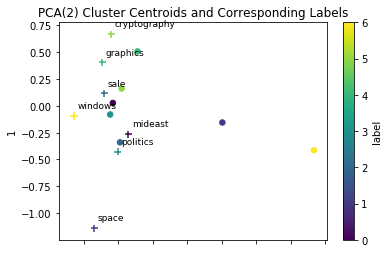

In [182]:
# Plot
centroid_pca.plot.scatter(x=0, y=1,
                  c='label',
                  s=30,
                  colormap='viridis')
plt.scatter(topics_pca[0], topics_pca[1], s=50, marker='+', c=topics_pca['label'])
for i, row in topics_pca.iterrows():
    plt.text(row[0]+0.05, row[1]+0.07, classes[int(row['label'])], fontsize=9)
plt.title('PCA(2) Cluster Centroids and Corresponding Labels')